This is for getting the ImageReward model

In [1]:
!git clone https://github.com/THUDM/ImageReward.git
%cd ImageReward
!pip install image-reward
!pip install git+https://github.com/openai/CLIP.git
import os
import torch
from PIL import Image
import ImageReward as RM  # Ensure ImageReward is correctly set up
from diffusers import StableDiffusionPipeline

Cloning into 'ImageReward'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 224 (delta 52), reused 49 (delta 41), pack-reused 133 (from 1)
Receiving objects: 100% (224/224), 4.30 MiB | 18.56 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/ImageReward
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 922.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/17

This is for running the imagereward model on the example

In [2]:

if __name__ == "__main__":
    prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
    img_prefix = "assets/images"
    generations = [f"{pic_id}.webp" for pic_id in range(1, 5)]
    img_list = [os.path.join(img_prefix, img) for img in generations]
    model = RM.load("ImageReward-v1.0")
    with torch.no_grad():
        ranking, rewards = model.inference_rank(prompt, img_list)
        # Print the result
        print("\nPreference predictions:\n")
        print(f"ranking = {ranking}")
        print(f"rewards = {rewards}")
        for index in range(len(img_list)):
            score = model.score(prompt, img_list[index])
            print(f"{generations[index]:>16s}: {score:.2f}")


ImageReward.pt:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

load checkpoint from /root/.cache/ImageReward/ImageReward.pt


med_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded

Preference predictions:

ranking = [1, 2, 3, 4]
rewards = [0.5811904668807983, 0.2745198607444763, -1.4158903360366821, -2.032487154006958]
          1.webp: 0.58
          2.webp: 0.27
          3.webp: -1.42
          4.webp: -2.03


This is the basic Reinforcement Learning code

In [3]:
import os
import torch
from PIL import Image
import ImageReward as RM  # Assuming ImageReward is correctly set up
from diffusers import StableDiffusionPipeline

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
med_config_path = "train/src/config/med_config.json"

# Initialize the ImageReward model
model = RM.load("ImageReward-v1.0").to(device)

# Define prompt and test images
prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
img_prefix = "assets/images"
generations = [f"{img_prefix}/{i}.webp" for i in range(1, 5)]
images = [Image.open(img_path).convert("RGB") for img_path in generations]

# Step 1: Determine Positive and Negative Images based on Initial Scores
def determine_pos_neg_images(model, prompt, images):
    scores = []
    for img in images:
        score = model.score(prompt, img)
        scores.append(score)
    sorted_images = [x for _, x in sorted(zip(scores, images), key=lambda pair: pair[0], reverse=True)]
    pos_image, neg_image = sorted_images[0], sorted_images[-1]  # highest score as positive, lowest as negative
    print(f"Positive Image Score: {scores[0]}, Negative Image Score: {scores[-1]}")
    return pos_image, neg_image

# Select positive and negative images based on scores
pos_image, neg_image = determine_pos_neg_images(model, prompt, images)

# Step 2: Contrastive Learning Function
def contrastive_learning_step(model, prompt, pos_image, neg_image, optimizer, accumulation_steps=4, initial_margin=0.2, margin_growth=0.1):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    # Tokenize prompt
    text_input = model.blip.tokenizer(prompt, padding="max_length", truncation=True, max_length=35, return_tensors="pt").to(device)
    prompt_ids = text_input.input_ids
    prompt_attention_mask = text_input.attention_mask

    # Prepare positive and negative images
    pos_image_tensor = model.preprocess(pos_image).unsqueeze(0).to(device)
    neg_image_tensor = model.preprocess(neg_image).unsqueeze(0).to(device)

    margin = initial_margin

    # Perform contrastive training
    for step in range(accumulation_steps):
        pos_reward = model.score_gard(prompt_ids, prompt_attention_mask, pos_image_tensor)
        neg_reward = model.score_gard(prompt_ids, prompt_attention_mask, neg_image_tensor)

        # Print for debugging
        print(f"Pos Reward: {pos_reward.item()}, Neg Reward: {neg_reward.item()}")

        # Adjust margin if difference is too large
        if pos_reward - neg_reward > margin:
            margin += margin_growth

        # Calculate contrastive loss with dynamic margin
        loss = torch.relu(margin - pos_reward + neg_reward) / accumulation_steps
        total_loss += loss.item()

        # Accumulate gradients only if loss is non-zero
        if loss.item() > 0:
            loss.backward(retain_graph=(step < accumulation_steps - 1))

    optimizer.step()
    optimizer.zero_grad()

    return total_loss



# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Run contrastive learning
contrastive_loss = contrastive_learning_step(model, prompt, pos_image, neg_image, optimizer)
print(f"Contrastive Learning Loss: {contrastive_loss}")

# Step 3: Reinforcement Learning Pipeline with Score-Based Feedback
class ReinforcementLearningPipeline:
    def __init__(self, reward_model, diffusion_model, device):
        self.reward_model = reward_model
        self.diffusion_model = diffusion_model
        self.device = device

    def reinforcement_learning_loop(self, prompt, num_iterations=8, lr=1e-4):
        optimizer = torch.optim.Adam(self.diffusion_model.unet.parameters(), lr=lr)
        best_image, best_score = None, -float('inf')

        for iteration in range(num_iterations):
            generated_image = self.diffusion_model(prompt).images[0].convert("RGB")
            score = self.reward_model.score(prompt, generated_image)
            print(f"Iteration {iteration + 1}/{num_iterations}, Score: {score}")

            # Loss as negative score to maximize positive score
            loss = -torch.tensor(score, requires_grad=True, device=self.device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track best scoring image
            if score > best_score:
                best_score = score
                best_image = generated_image

        return best_image, best_score

# Initialize and run RL loop
diffusion_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
rl_pipeline = ReinforcementLearningPipeline(model, diffusion_model, device)
best_image, best_score = rl_pipeline.reinforcement_learning_loop(prompt, num_iterations=20)
best_image.show()
print(f"Best Reinforcement Score: {best_score}")



load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded
Positive Image Score: 0.5811904668807983, Negative Image Score: -2.032487154006958
Pos Reward: 0.5168375372886658, Neg Reward: -2.186016798019409
Pos Reward: 0.4461417496204376, Neg Reward: -1.895283579826355
Pos Reward: 0.43822750449180603, Neg Reward: -0.6532754898071289
Pos Reward: 0.3770948350429535, Neg Reward: -2.023538589477539
Contrastive Learning Loss: 0.0


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1/20, Score: -0.6676912903785706


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 2/20, Score: -1.2953317165374756


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3/20, Score: -1.2707748413085938


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 4/20, Score: 0.3689015209674835


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 5/20, Score: -1.3692598342895508


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 6/20, Score: -0.15823595225811005


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 7/20, Score: 0.041149239987134933


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 8/20, Score: 0.017705878242850304


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9/20, Score: 0.5335131883621216


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 10/20, Score: -0.7828595042228699


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 11/20, Score: -0.3621889352798462


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 12/20, Score: -0.4259440302848816


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 13/20, Score: 0.6696153879165649


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 14/20, Score: -0.4568961262702942


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 15/20, Score: -1.4999580383300781


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 16/20, Score: -1.4082704782485962


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 17/20, Score: -1.7074838876724243


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 18/20, Score: -1.7166377305984497


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 19/20, Score: -1.2520766258239746


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 20/20, Score: -0.8673915863037109
Best Reinforcement Score: 0.6696153879165649


Run the below code to show the best image

Image saved at best_generated_image.png


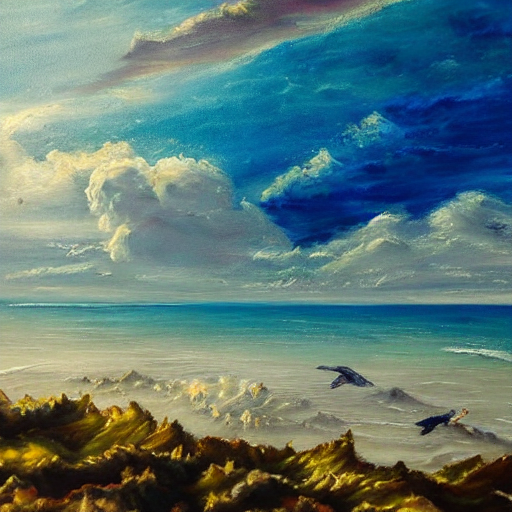

In [4]:
from IPython.display import display
from PIL import Image

# Set a path to save the image
output_image_path = "best_generated_image.png"

# Save the image if it exists
if best_image:
    best_image.save(output_image_path)
    print(f"Image saved at {output_image_path}")

    # Display the saved image in a notebook or script
    display(Image.open(output_image_path))
else:
    print("No image generated.")

This is the Proximal Policy Optimization (PPO) Reinforcement Learning


In [5]:
import os
import torch
from PIL import Image
import ImageReward as RM  # Assuming ImageReward is correctly set up
from diffusers import StableDiffusionPipeline

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ImageReward model and diffusion model
model = RM.load("ImageReward-v1.0").to(device)
diffusion_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

# Define prompt and test images
prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
img_prefix = "assets/images"
generations = [f"{img_prefix}/{i}.webp" for i in range(1, 5)]
images = [Image.open(img_path).convert("RGB") for img_path in generations]

# Step 1: Determine Positive and Negative Images based on Initial Scores
def determine_pos_neg_images(model, prompt, images):
    scores = []
    for img in images:
        score = model.score(prompt, img)
        scores.append(score)
    sorted_images = [x for _, x in sorted(zip(scores, images), key=lambda pair: pair[0], reverse=True)]
    pos_image, neg_image = sorted_images[0], sorted_images[-1]
    print(f"Positive Image Score: {scores[0]}, Negative Image Score: {scores[-1]}")
    return pos_image, neg_image

# Select positive and negative images based on scores
pos_image, neg_image = determine_pos_neg_images(model, prompt, images)

# Step 2: Contrastive Learning Function
def contrastive_learning_step(model, prompt, pos_image, neg_image, optimizer, accumulation_steps=4, initial_margin=0.2, margin_growth=0.1):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    # Tokenize prompt
    text_input = model.blip.tokenizer(prompt, padding="max_length", truncation=True, max_length=35, return_tensors="pt").to(device)
    prompt_ids = text_input.input_ids
    prompt_attention_mask = text_input.attention_mask

    # Prepare positive and negative images
    pos_image_tensor = model.preprocess(pos_image).unsqueeze(0).to(device)
    neg_image_tensor = model.preprocess(neg_image).unsqueeze(0).to(device)

    margin = initial_margin

    # Perform contrastive training
    for step in range(accumulation_steps):
        pos_reward = model.score_gard(prompt_ids, prompt_attention_mask, pos_image_tensor)
        neg_reward = model.score_gard(prompt_ids, prompt_attention_mask, neg_image_tensor)

        # Adjust margin if difference is too large
        if pos_reward - neg_reward > margin:
            margin += margin_growth

        # Calculate contrastive loss with dynamic margin
        loss = torch.relu(margin - pos_reward + neg_reward) / accumulation_steps
        total_loss += loss.item()

        # Accumulate gradients only if loss is non-zero
        if loss.item() > 0:
            loss.backward(retain_graph=(step < accumulation_steps - 1))

    optimizer.step()
    optimizer.zero_grad()

    return total_loss

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Run contrastive learning
contrastive_loss = contrastive_learning_step(model, prompt, pos_image, neg_image, optimizer)
print(f"Contrastive Learning Loss: {contrastive_loss}")

# Step 3: PPO-based RL Pipeline with Simplified Reward Shaping
class PPOReinforcementLearningPipeline:
    def __init__(self, reward_model, diffusion_model, device, epsilon=0.3, gamma=0.99, lr=1e-4):
        self.reward_model = reward_model
        self.diffusion_model = diffusion_model
        self.device = device
        self.epsilon = epsilon  # PPO clipping parameter
        self.gamma = gamma      # Discount factor for reward
        self.optimizer = torch.optim.Adam(self.diffusion_model.unet.parameters(), lr=lr)

    def ppo_loss(self, new_reward, old_reward=None):
        if old_reward is None:
            old_reward = new_reward  # Initial case
        advantage = (new_reward - old_reward).detach()  # Ensure advantage is detached from computation graph
        clipped_advantage = torch.clamp(advantage, min=1 - self.epsilon, max=1 + self.epsilon)
        return -torch.min(advantage * new_reward, clipped_advantage * new_reward).mean()

    def reinforcement_learning_loop(self, prompt, num_iterations=5):
        best_image, best_score = None, -float('inf')

        for iteration in range(num_iterations):
            generated_image = self.diffusion_model(prompt).images[0].convert("RGB")
            score = self.reward_model.score(prompt, generated_image)

            # Convert score to a tensor
            score_tensor = torch.tensor(score, requires_grad=True, device=self.device)

            # Calculate PPO loss
            loss = self.ppo_loss(score_tensor)
            print(f"Iteration {iteration + 1}/{num_iterations}")

            # Optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if score > best_score:
                best_score = score
                best_image = generated_image

            # Free up memory by detaching tensors
            loss.detach()
            torch.cuda.empty_cache()

        return best_image, best_score

# Run PPO-based RL loop
rl_pipeline = PPOReinforcementLearningPipeline(model, diffusion_model, device)
best_image, best_score = rl_pipeline.reinforcement_learning_loop(prompt)
best_image.show()
print(f"Best Reinforced Image Score: {best_score}")


load checkpoint from /root/.cache/ImageReward/ImageReward.pt
checkpoint loaded


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Positive Image Score: 0.5811904668807983, Negative Image Score: -2.032487154006958
Contrastive Learning Loss: 0.05206140875816345


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3/5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 4/5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 5/5
Best Reinforced Image Score: 1.521492600440979


Run the code below to to get the picture using the PPO RL model

Image saved at best_generated_image.png


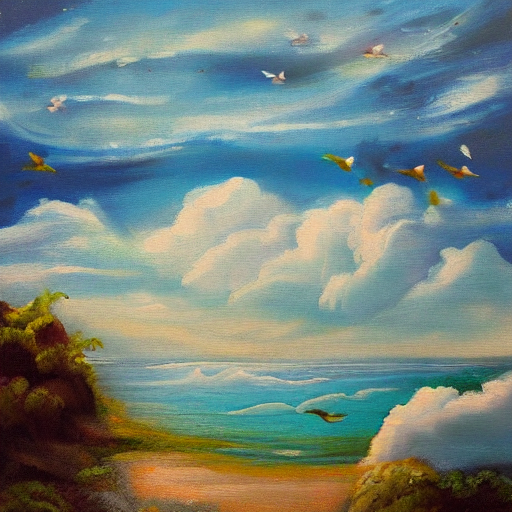

In [6]:
import os
from IPython.display import display
from PIL import Image

# Set a path to save the image
output_image_path = "best_generated_image.png"

# Save the image if it exists
if best_image:
    best_image.save(output_image_path)
    print(f"Image saved at {output_image_path}")

    # Display the saved image in a notebook or script
    display(Image.open(output_image_path))
else:
    print("No image generated.")
